In [41]:
# make imports work
import sys
sys.path.insert(0, "/Users/JonathanHeitz/git/dementia/src/")

import matplotlib.pyplot as plt
import os
from sklearn import metrics as sk_metrics
import json
import numpy as np
import pandas as pd
import re, glob
from collections import defaultdict
from IPython.display import Image, display
import matplotlib.image as mpimg
from config.config import Config


## Data collection
First, let's load the results from the result directories, and bring them in a form we can analyse more easily

In [47]:

# load directories from results dir that contain the results we're interested in
base_dir = '/Volumes/methlab/Students/Jonathan/results/runs'
results_base_dir = ["2023_kw40"] # 10 runs of everything...
results_dirs = [os.path.join(base_dir, base) for base in results_base_dir if os.path.exists(os.path.join(base_dir, base, "metrics.txt"))] +\
               [os.path.join(parent, dir) for base in results_base_dir for parent, dirs, _ in os.walk(os.path.join(base_dir, base)) for dir in dirs if os.path.exists(os.path.join(parent, dir, "metrics.txt"))]


labels = defaultdict(lambda: [])
predictions = defaultdict(lambda: [])
dirs = defaultdict(lambda: [])
for d in results_dirs:
    # prepare data for results analysis
    # go through all results dirs, extract relevant information from e.g. config file, and condense them in parameter_string, which identifies a unique set of settings
    basename = os.path.basename(d)
    yaml_file = [f for f in os.listdir(d) if f.endswith(".yaml")][0]
    config = Config.from_yaml(os.path.join(d, yaml_file))

    try:
        preprocessors = str([path.preprocessors for path in config.pipeline]).replace("[['Audio Features'], ['Linguistic Features']]", "AudioF+LinguF")
        print(preprocessors)
    except:
        preprocessors = "+".join(config.preprocessors).replace("Linguistic Features Literature", "LinguFL").replace("Other Model Prediction", "BERT").replace("Automatic Punctuation", "Punct").replace("Audio Features", "AudioF")
        preprocessors = preprocessors.replace("ASR google_speech", "Google").replace("ASR wave2vec2", "w2v").replace("ASR whisper", "Whisper").replace("PAR segmentation", "cut")

    #data_params = f"par{int(config.config_data['only_PAR'])},pause{int(config.config_data['keep_pauses'])},term{int(config.config_data['keep_terminators'])},unint{int(config.config_data['keep_unintelligable_speech'])}"
    try:
        data = config.data
    except:
        data = str([path.data for path in config.pipeline])
    data = data.replace("ADReSS_audio", "ADR").replace("ADReSS_with_PITT_audio", "ADR_PITT").replace("ADReSS_manual_transcripts", "manual")
    model = config.model.replace("RandomForest", "RF").replace("GradientBoosting", "GB").replace("BERT_NEW","BERT")

    try:
        chat_parser_version = config.chat_parser_version
    except:
        chat_parser_version = "default"

    try:
        inv_par = config.config_data.only_PAR == False
    except:
        inv_par = False

    parameter_string = f"{data} {preprocessors} {model}"# {run_version}"#({data_params})"

    parameter_string_mapping = {
        'ADR cut+w2v BERT': 'Wave2vec2 BERT',
        'ADR cut+Google BERT': 'GoogleSpeech BERT',
        'ADR cut+Whisper+LinguFL RF': 'Whisper Linguistic',
        'ADR cut+Whisper BERT': 'Whisper BERT',
        'ADR cut+w2v+LinguFL RF': 'Wave2vec2 Linguistic',
        'ADR cut+Google+LinguFL RF': 'GoogleSpeech Linguistic',
        'manual  BERT': 'Manual BERT',
        'manual LinguFL RF': "Manual Linguistic"
    }
    parameter_string = parameter_string_mapping.get(parameter_string, parameter_string)


    dirs[parameter_string].append(d)

    with open(os.path.join(d, "predictions.txt"), "r") as f:
        data = json.load(f)
        flat = [item for items in data for item in items]
        predictions[parameter_string].append(flat)
    with open(os.path.join(d, "labels.txt"), "r") as f:
        data = json.load(f)
        flat = [item for items in data for item in items]
        labels[parameter_string].append(flat)


print(*[f"{parameter_string}: {len(predictions[parameter_string])} results" for parameter_string in predictions], sep="\n")

GoogleSpeech BERT: 80 results
Wave2vec2 BERT: 80 results
Manual BERT: 80 results
Whisper BERT: 80 results
GoogleSpeech Linguistic: 10 results
Whisper Linguistic: 10 results
Wave2vec2 Linguistic: 10 results
Manual Linguistic: 10 results


## Analysis and plotting of results
Next, let's analyze the results
- For BERT models, we first combine 8 models into one by averaging the 8 predictions
- For other models, each model is considered separately

We calculate mean and std to capture variability due to random initialization

majority_metrics_collected outer []
Manual BERT 80 0.898586456278764 0.008533722541753174
Manual Linguistic 10 0.8881245890861275 0.003056945140835695
majority_metrics_collected outer []
GoogleSpeech BERT 80 0.837146614069691 0.009514990881058422
majority_metrics_collected outer []
Whisper BERT 80 0.8009533201840894 0.009397628112375324
majority_metrics_collected outer []
Wave2vec2 BERT 80 0.8193622616699541 0.012759044471278827
GoogleSpeech Linguistic 10 0.8649079552925707 0.004152922555082219
Whisper Linguistic 10 0.8478057199211045 0.003811447123710478
Wave2vec2 Linguistic 10 0.8601166995397765 0.003641624362613465


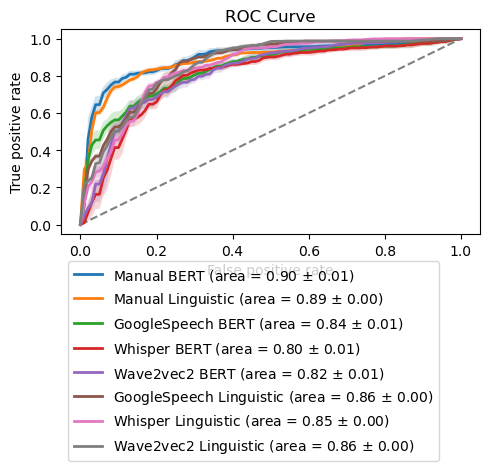

majority_metrics_collected outer []
Manual BERT 80 0.8365384615384615 0.013215082133389936
Manual Linguistic 10 0.8211538461538461 0.011268202455927532
majority_metrics_collected outer []
GoogleSpeech BERT 80 0.7519230769230769 0.014909876089247443
majority_metrics_collected outer []
Whisper BERT 80 0.7564102564102564 0.014617633655117148
majority_metrics_collected outer []
Wave2vec2 BERT 80 0.7467948717948718 0.012577831327146537
GoogleSpeech Linguistic 10 0.7923076923076924 0.007138159439525686
Whisper Linguistic 10 0.7852564102564102 0.01119503153626472
Wave2vec2 Linguistic 10 0.7730769230769231 0.005875097044815178


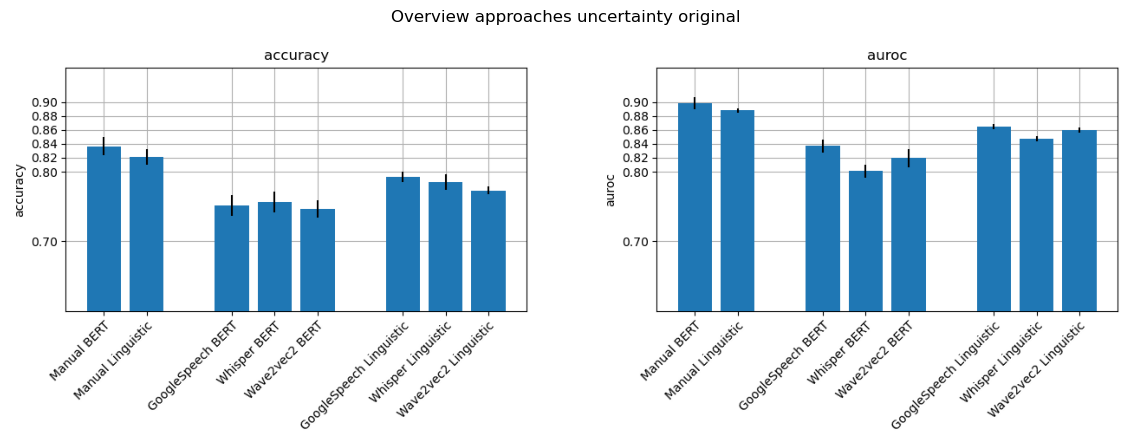

,Approach,auroc,accuracy
0,Manual BERT,$0.899 \pm 0.009$,$0.837 \pm 0.013$
1,Manual Linguistic,$0.888 \pm 0.003$,$0.821 \pm 0.011$
2,,,
3,GoogleSpeech BERT,$0.837 \pm 0.010$,$0.752 \pm 0.015$
4,Whisper BERT,$0.801 \pm 0.009$,$0.756 \pm 0.015$
5,Wave2vec2 BERT,$0.819 \pm 0.013$,$0.747 \pm 0.013$
6,,,
7,GoogleSpeech Linguistic,$0.865 \pm 0.004$,$0.792 \pm 0.007$
8,Whisper Linguistic,$0.848 \pm 0.004$,$0.785 \pm 0.011$
9,Wave2vec2 Linguistic,$0.860 \pm 0.004$,$0.773 \pm 0.006$


\begin{tabular}{lll}
\toprule
Approach & auroc & accuracy \\
\midrule
Manual BERT & $0.899 \pm 0.009$ & $0.837 \pm 0.013$ \\
Manual Linguistic & $0.888 \pm 0.003$ & $0.821 \pm 0.011$ \\
 &  &  \\
GoogleSpeech BERT & $0.837 \pm 0.010$ & $0.752 \pm 0.015$ \\
Whisper BERT & $0.801 \pm 0.009$ & $0.756 \pm 0.015$ \\
Wave2vec2 BERT & $0.819 \pm 0.013$ & $0.747 \pm 0.013$ \\
 &  &  \\
GoogleSpeech Linguistic & $0.865 \pm 0.004$ & $0.792 \pm 0.007$ \\
Whisper Linguistic & $0.848 \pm 0.004$ & $0.785 \pm 0.011$ \\
Wave2vec2 Linguistic & $0.860 \pm 0.004$ & $0.773 \pm 0.006$ \\
\bottomrule
\end{tabular}


In [48]:
!# Let's plot the results

def get_metrics_flat(metric_name, predictions_flat, labels_flat):
    predictions_rounded = np.round(np.array(predictions_flat))
    metrics = {
        'accuracy': sk_metrics.accuracy_score(labels_flat, predictions_rounded),
        'recall / sensitivity': sk_metrics.recall_score(labels_flat, predictions_rounded),
        'specificity': sk_metrics.recall_score(labels_flat, predictions_rounded, pos_label=0),
        'precision': sk_metrics.precision_score(labels_flat, predictions_rounded),
        'auroc': sk_metrics.roc_auc_score(labels_flat, predictions_flat),
        # average_precision = Area under the PR curve (https://en.wikipedia.org/w/index.php?title=Information_retrieval&oldid=793358396#Average_precision)
        'average_precision': sk_metrics.average_precision_score(labels_flat, predictions_flat),
        'log_loss': sk_metrics.log_loss(labels_flat, predictions_flat)
    }
    return metrics[metric_name]

def calculate_average_prediction(predictions_numpy, labels_numpy):
    # Average prediction of each sample over the runs: Every run gives different predictions, the average is a more stable prediction
    average_prediction, average_label = np.mean(predictions_numpy, axis=0), np.mean(labels_numpy, axis=0)

    return average_prediction, average_label

def calculate_metric_for_setting(metric_name, predictions_numpy, labels_numpy):
    # calculate mean and std metric over multiple runs
    metrics_run = []
    for labels, predictions in zip(labels_numpy, predictions_numpy):
        metrics_run.append(get_metrics_flat(metric_name, predictions, labels))

    mean_metric = np.array(metrics_run).mean()
    std_metric = np.array(metrics_run).std()

    return mean_metric, std_metric, np.array(metrics_run)

def calculate_roc_curves(predictions_numpy, labels_numpy):
    # Calculate ROC curves for the average prediction in predictions_numpy
    average_prediction, average_label = np.mean(predictions_numpy, axis=0), np.mean(labels_numpy, axis=0)
    average_fpr, average_tpr, _ = sk_metrics.roc_curve(average_label, average_prediction)
    #average_auroc = sk_metrics.auc(average_fpr, average_tpr)

    # calculate individual ROC curves
    all_fpr_numpy, all_tpr_numpy, all_auroc = [], [], []
    for labels, predictions in zip(labels_numpy, predictions_numpy):
        fpr, tpr, _ = sk_metrics.roc_curve(labels, predictions)
        auroc = sk_metrics.auc(fpr, tpr)
        all_fpr_numpy.append(fpr)
        all_tpr_numpy.append(tpr)
        all_auroc.append(auroc)

    # interpolated tprs of the individual runs and base fpr for average curve
    tprs = []
    base_fpr = np.linspace(0, 1, 101)

    # mean and std for average curve
    mean_auc = np.mean(all_auroc, axis=0)
    std_auc = np.std(all_auroc, axis=0)

    # iterate individual curves
    for i, (fpr, tpr, auroc) in enumerate(zip(all_fpr_numpy, all_tpr_numpy, all_auroc)):
        # plt.plot(fpr, tpr, 'k', label='Run {} (area = {:.2f})'.format(i, auroc), lw=1)

        # interpolate according to base_fpr -> this is to allow for averaging
        tpr = np.interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0
        tprs.append(tpr)

    # average tpr for base_fpr
    tprs = np.array(tprs)
    mean_tpr = tprs.mean(axis=0)
    std_tpr = tprs.std(axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

    return (mean_tpr, std_tpr, mean_auc, std_auc), (base_fpr, tprs_lower, tprs_upper)


def plot_results_plots_for_metric(metric_name, predictions, labels, figsize=(10, 5), show=True, group_sizes=()):
    # for one metric (metric_name), plot the box plot of results
    # if the metric is auroc, also plot the ROC curve
    
    # mean and std metrics (for metric_name), for the different parameter_strings (training settings)
    mean_metrics, std_metrics = [], []
    
    # the distributino of these metrics (of which mean and std are calculated), to be returned for further analysis
    metric_distributions = {}

    # roc curves, if metric is auroc    
    roc_curves = []
    
    def sort_key(x):
        x = x.lower()
        data_key = 1 if 'manual' in x else 3 if 'adr_pitt'  in x else 2
        algo_key = 1 if 'bert' in x else 2
        asr_key = 1 if 'manual' in x else 2 if 'google' in x else 3 if 'whisper' in x else 4 if 'w2v' in x else 5#
        cut_key = 2 if 'cut' in x else 1
        #print(x, algo_key, asr_key)
        return data_key, cut_key, algo_key, asr_key
    settings = sorted([parameter_string for parameter_string in predictions], key=sort_key)

    for parameter_string in settings:
        if 'bert' in parameter_string.lower():
            # bert: repeatedly sample 8 runs and calculate mean and std of majority vote metric
            assert (len(predictions[parameter_string]) >= 8), len(predictions[parameter_string])
            average_metrics_collected = []

            # take the original folders (e.g. 00000000_0000_asdf_overview), each containing 8 runs to get the values for mean and std calculation
            folder_hashes = [re.findall(r"_([a-zA-Z0-9]{4})_overview", d)[0] for d in dirs[parameter_string]]
            distinct_folder_hashes = list(set(folder_hashes))
            #print("distinct_folder_hashes", distinct_folder_hashes)
            n_drawings = len(distinct_folder_hashes)
            get_sample_runs = lambda drawing: [i for i, hash in enumerate(folder_hashes) if hash == distinct_folder_hashes[drawing]]
            
            
            average_predictions, average_labels = [], []
            for drawing in range(n_drawings):
                # one drawing is 8 runs of BERT
                sample_runs = get_sample_runs(drawing)
                
                # calculate average (ensemble) prediction of the 8 runs
                average_prediction, average_label = calculate_average_prediction(np.array(predictions[parameter_string])[sample_runs], np.array(labels[parameter_string])[sample_runs])
                average_predictions.append(average_prediction)
                average_labels.append(average_label)
            print("majority_metrics_collected outer", average_metrics_collected)
            mean_metric, std_metric, metric_distribution = calculate_metric_for_setting(metric_name, np.array(average_predictions), np.array(average_labels))
            roc_curves.append((np.array(average_predictions), np.array(average_labels)))

        else:
            # simple run, just take the mean and std metric over all available runs directly
            assert(len(predictions[parameter_string]) <= 10), f"{len(predictions[parameter_string])} {parameter_string}"
            mean_metric, std_metric, metric_distribution = calculate_metric_for_setting(metric_name, predictions[parameter_string], labels[parameter_string])
            roc_curves.append((predictions[parameter_string], labels[parameter_string]))

        print(parameter_string, len(predictions[parameter_string]), mean_metric, std_metric)

        mean_metrics.append(mean_metric)
        std_metrics.append(std_metric)
        metric_distributions[parameter_string] = metric_distribution

    ## BAR PLOT
    bar_heights = mean_metrics
    
    # check if group_sizes match: the sum of all groups should correspond to the number of bars
    assert len(bar_heights) == np.sum(group_sizes), f"Group sizes do not work. We have {len(bar_heights)} results for group sizes {group_sizes} (total: {np.sum(group_sizes)})"

    # group_sizes = size of the groups in the plot (spaces between)
    space_positions = [sum(group_sizes[:i+1])+i for i in range(len(group_sizes))]

    # the label locations
    x = np.arange(len(settings) + len(space_positions))
    x = np.array([i for i in x if i not in space_positions])

    width = 0.8
    label_offset = 0

    fig, ax = plt.subplots(layout='constrained', figsize=figsize)
    ax.grid(zorder=0)
    yerr = np.array(std_metrics)
    rects = ax.bar(x, bar_heights, width, yerr=yerr, zorder=3)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(f'{metric_name}')
    #ax.set_xlabel('Version')
    ax.set_title(f"{metric_name}")
    ax.set_xticks(x + label_offset, [s for s in settings], rotation=45, ha='right', rotation_mode='anchor')
    ax.set_ylim(0.6, 0.95)
    ax.set_yticks(np.array([70,80,82,84,86,88,90])/100)
    filepath = f"plots/{metric_name.replace(' / ', '_').replace(' ', '_')}_bar.png"
    plt.savefig(filepath)
    if show:
        plt.show()
    else:
        plt.close()


    # ROC curves
    if metric_name == 'auroc':
        fig, (ax1) = plt.subplots(1, 1, figsize=(5,5))
        ax1.plot([0, 1], [0, 1], 'k--', alpha=0.5)
        ax1.set_title("ROC Curve")
    
        for ((predictions, labels), setting) in zip(roc_curves, settings):
            (mean_tpr, std_tpr, mean_auc, std_auc), (base_fpr, tprs_lower, tprs_upper) = calculate_roc_curves(predictions, labels)
            label = setting
            label += fr" (area = {mean_auc:0.2f} $\pm$ {std_auc:0.2f})" if std_auc > 0 else f" (area = {mean_auc:0.2f})"
            ax1.plot(base_fpr, mean_tpr, label=label, lw=2)
            ax1.fill_between(
                base_fpr,
                tprs_lower,
                tprs_upper,
                #color="grey",
                alpha=0.2,
                #label=r"$\pm$ 1 std. dev.",
            )
    
        ax1.set_xlabel('False positive rate')
        ax1.set_ylabel('True positive rate')
    
        #plt.title('ROC curve')
        ax1.legend(bbox_to_anchor=(-0, -0.1), loc="upper left")
        plt.tight_layout()
        plt.savefig(f"plots/roc.png")
        plt.show()

    return filepath, settings, mean_metrics, std_metrics, metric_distributions


def show_all_metrics_grid(experiment_name, metrics, predictions, labels, figsize_individual=(5,4), group_sizes=()):
    # For each metric in metrics, show a box plot with the results, and write Latex code for the results table

    # calculate individual box plots (and plot ROC curve, if m == 'auroc')
    individual_plots = [(m, plot_results_plots_for_metric(m, predictions, labels, figsize_individual, show=False, group_sizes=group_sizes)) for m in metrics]
    
    # distribution of results for each metric, will be returned from this function, to calculate t-test for significant difference further down
    results_distribution = {}
    
    # initialize figure
    n_cols = int(np.ceil(np.sqrt(len(metrics))))
    n_rows = int(np.ceil(len(metrics) / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*figsize_individual[0], n_rows*figsize_individual[1]))
    if n_rows > 1:
        axes = [item for list in axes for item in list]
    elif n_rows == 1 and n_cols == 1:
        axes = [axes]
    [axis.set_axis_off() for axis in axes]
    [axis.set_xticklabels([]) for axis in axes]
    [axis.set_yticklabels([]) for axis in axes]
    idx = 0
    plt.rcParams["figure.autolayout"] = True

    # load individual box plots and show in grid
    for metric, (path, settings, mean_metrics, std_metrics, metric_distributions) in sorted(individual_plots):
        img = mpimg.imread(path)
        axes[idx].imshow(img)
        idx += 1
        results_distribution[metric] = metric_distributions
        
    # finalize plot
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle(f"{experiment_name}")
    experiment_name_part = experiment_name.replace(" ", "_").lower()
    plt.tight_layout()
    plt.savefig(f"plots/combined_metrics_{experiment_name_part}.png")
    plt.show()

    # prepare and print Latex table
    model_metrics = [pd.DataFrame({'Approach': settings, metric: [fr"${mean:.3f} \pm {std:.3f}$" for mean, std in zip(mean_metrics, std_metrics)]}) for metric, (path, settings, mean_metrics, std_metrics, metric_distributions) in individual_plots]
    models_table = model_metrics[0]
    for m in model_metrics[1:]:
        models_table = models_table.merge(m, on="Approach", how="outer")
    models_table_sections = []
    i = 0
    for _, size in enumerate(group_sizes):
        section = models_table.iloc[i:i+size, :]
        models_table_sections.append(section)
        if i+size < models_table.shape[0]:
            # add empty row
            models_table_sections.append(pd.DataFrame.from_dict({c: [""] for c in section.columns}, orient='columns'))
        i += size
    models_table_with_spacing = pd.concat(models_table_sections, ignore_index=True)
    display(models_table_with_spacing)
    latex_code = models_table_with_spacing.to_latex(index=False)
    print(latex_code)


    return results_distribution


results_distribution = show_all_metrics_grid("Overview approaches uncertainty original", ['auroc', 'accuracy'], predictions, labels, figsize_individual=(6,4.5), group_sizes=[2,3,3])
#, 0, 2,2, 2,2, 2,2, 0, 2,2, 2,2, 2,2


## Statistical testing
Next, let's do statistical testing.

We statistically analyze performance differences between settings by performing a series of pairwise permutation tests. A permutation test repeatedly shuffles AUROCs of both settings into two groups and computes the groups’ difference in mean, then compares the observed difference to the randomly generated differences. For both BERT and RF, we compare the use of manual vs. ASR transcripts (2 tests), and we conduct pairwise comparisons between the different ASR systems (2 × 3 tests). In addition, we separately compare BERT against RF for manual and ASR transcripts (2 tests). This results in 10 tests, and we apply the Bonferroni Correction (Bonferroni, 1936) to coun- teract the multiple testing problem, resulting in a significance level of 0.05/10 = 0.005.

In [49]:
# let's look at format of results_distributions
results_distribution['auroc']

{'Manual BERT': array([0.8969428 , 0.90006575, 0.89940828, 0.91370809, 0.89053254,
        0.89003945, 0.90351742, 0.88247863, 0.90417488, 0.90499671]),
 'Manual Linguistic': array([0.88634122, 0.88699869, 0.89151874, 0.8874096 , 0.89299803,
        0.89151874, 0.88888889, 0.88617686, 0.88206772, 0.88732742]),
 'GoogleSpeech BERT': array([0.82725181, 0.83251151, 0.83744247, 0.83629191, 0.85880999,
        0.83086785, 0.84286654, 0.82560815, 0.8330046 , 0.84681131]),
 'Whisper BERT': array([0.82232084, 0.79799474, 0.79832347, 0.8086785 , 0.79207758,
        0.79092702, 0.80769231, 0.79026956, 0.79815911, 0.80309007]),
 'Wave2vec2 BERT': array([0.81278764, 0.82938856, 0.8334977 , 0.82100592, 0.80276134,
        0.81377383, 0.83744247, 0.82659435, 0.79503616, 0.82133465]),
 'GoogleSpeech Linguistic': array([0.87056213, 0.86357659, 0.86711045, 0.86719264, 0.85724852,
        0.86390533, 0.86900066, 0.86012492, 0.86135766, 0.86900066]),
 'Whisper Linguistic': array([0.84861933, 0.84853715, 

In [50]:
records = [(metric, approach, res) for metric in results_distribution for approach in results_distribution[metric] for res in results_distribution[metric][approach]]
results_df = pd.DataFrame.from_records(records, columns=['metric', 'run_name', 'result'])
results_df['transcription_type'] = results_df.run_name.apply(lambda x: re.findall(r"(Manual|Wave2vec2|Whisper|GoogleSpeech)", x)[0].replace("Manual", "A_Manual"))
results_df['manual'] = results_df.run_name.apply(lambda x: re.findall(r"(Manual|Wave2vec2|Whisper|GoogleSpeech)", x)[0].replace("GoogleSpeech", "ASR").replace("Whisper", "ASR").replace("Wave2vec2", "ASR"))
results_df['approach'] = results_df.run_name.apply(lambda x: re.findall(r"(BERT|Linguistic)", x)[0])
display(results_df.query("metric == 'auroc'"))
display(results_df.query("metric == 'auroc'").transcription_type.value_counts(dropna=False))

,metric,run_name,result,transcription_type,manual,approach
80,auroc,Manual BERT,0.896943,A_Manual,Manual,BERT
81,auroc,Manual BERT,0.900066,A_Manual,Manual,BERT
82,auroc,Manual BERT,0.899408,A_Manual,Manual,BERT
83,auroc,Manual BERT,0.913708,A_Manual,Manual,BERT
84,auroc,Manual BERT,0.890533,A_Manual,Manual,BERT
...,...,...,...,...,...,...
155,auroc,Wave2vec2 Linguistic,0.864234,Wave2vec2,ASR,Linguistic
156,auroc,Wave2vec2 Linguistic,0.860125,Wave2vec2,ASR,Linguistic
157,auroc,Wave2vec2 Linguistic,0.856180,Wave2vec2,ASR,Linguistic
158,auroc,Wave2vec2 Linguistic,0.860536,Wave2vec2,ASR,Linguistic


transcription_type
A_Manual        20
GoogleSpeech    20
Whisper         20
Wave2vec2       20
Name: count, dtype: int64

In [51]:
from scipy import stats

asr_systems = ['GoogleSpeech', 'Wave2vec2', 'Whisper']


# let's run sum permutation tests
# https://www.cfholbert.com/blog/two_sample_permutation_test/#:~:text=Permutation%20tests%20are%20used%20to,assuming%20data%20follow%20normal%20distributions
def permutation_test(results_a, results_b, alpha):
    size_a, size_b = np.array(results_a).size, np.array(results_b).size
    results_combined = np.concatenate((results_a, results_b))
    observed_diff = np.mean(results_a) - np.mean(results_b)

    # get random assignment to groups, and their diff in result means
    n_samples = 10000
    mean_diff_distribution = []
    for _ in range(n_samples):
        permuted_results = np.random.permutation(results_combined)
        mean_diff_distribution.append(np.mean(permuted_results[:size_a]) - np.mean(permuted_results[size_a:]))
    quantiles = np.quantile(mean_diff_distribution, [alpha/2, 1-alpha/2])
    significant = quantiles[0] > observed_diff or quantiles[1] < observed_diff
    assert significant == (np.sum(np.abs(observed_diff) < np.abs(mean_diff_distribution)) / len(mean_diff_distribution) < alpha)
    assert isinstance(observed_diff, np.float64) and len(mean_diff_distribution) == n_samples
    res = {'significant': "*" if significant else "",
            'Observed AUROC Diff': observed_diff,
            # For a two-sided alternative hypothesis, the p-value is computed as the proportion of times the absolute values of the differences in the means (or medians) in the permutation distribution are greater than or equal to the absolute value of the observed difference in the means (or medians).
            'P-Value': np.sum(np.abs(observed_diff) < np.abs(mean_diff_distribution)) / len(mean_diff_distribution),
           }

    print(res)
    return res



test_results = []
for manual in ('Manual', 'ASR'):
    print(f"{manual}: BERT vs. Linguistic+RF:")
    res = permutation_test(results_df.query(f"metric == 'auroc' and manual == '{manual}' and approach == 'BERT'").result, results_df.query(f"metric == 'auroc' and manual == '{manual}' and approach == 'Linguistic'").result, alpha=0.05/10)
    test_results.append({'Test': f"{manual} transcripts: BERT vs. Linguistic+RF:", **res})


for approach in ('BERT', 'Linguistic'):
    print(f"manual or ASR for {approach}?")
    res = permutation_test(results_df.query(f"metric == 'auroc' and manual == 'Manual' and approach == '{approach}'").result, results_df.query(f"metric == 'auroc' and manual == 'ASR' and approach == '{approach}'").result, alpha=0.05/10)
    test_results.append({'Test': f"{approach.replace('Linguistic', 'Linguistic+RF')}: Manual vs. ASR transcripts", **res})




for approach in ('BERT', 'Linguistic'):
    for asr1, asr2 in [(asr1, asr2) for asr1 in asr_systems for asr2 in asr_systems if asr1 < asr2]:
        print(f"{asr1} vs {asr2} for {approach}?")
        res = permutation_test(results_df.query(f"metric == 'auroc' and manual == 'ASR' and approach == '{approach}' and transcription_type=='{asr1}'").result, results_df.query(f"metric == 'auroc' and manual == 'ASR' and approach == '{approach}' and transcription_type=='{asr2}'").result, alpha=0.05/10)
        test_results.append({'Test': f"{approach.replace('Linguistic', 'Linguistic+RF')}: {asr1} vs. {asr2}", **res})



Manual: BERT vs. Linguistic+RF:
{'significant': '*', 'Observed AUROC Diff': 0.010461867192636531, 'P-Value': 0.0026}
ASR: BERT vs. Linguistic+RF:
{'significant': '*', 'Observed AUROC Diff': -0.038456059609905946, 'P-Value': 0.0}
manual or ASR for BERT?
{'significant': '*', 'Observed AUROC Diff': 0.07943239097085264, 'P-Value': 0.0}
manual or ASR for Linguistic?
{'significant': '*', 'Observed AUROC Diff': 0.030514464168310163, 'P-Value': 0.0}
GoogleSpeech vs Wave2vec2 for BERT?
{'significant': '*', 'Observed AUROC Diff': 0.01778435239973697, 'P-Value': 0.0028}
GoogleSpeech vs Whisper for BERT?
{'significant': '*', 'Observed AUROC Diff': 0.03619329388560166, 'P-Value': 0.0}
Wave2vec2 vs Whisper for BERT?
{'significant': '*', 'Observed AUROC Diff': 0.018408941485864694, 'P-Value': 0.0033}
GoogleSpeech vs Wave2vec2 for Linguistic?
{'significant': '', 'Observed AUROC Diff': 0.004791255752794155, 'P-Value': 0.0188}
GoogleSpeech vs Whisper for Linguistic?
{'significant': '*', 'Observed AUROC 

In [52]:
# collect into table
test_results_df = pd.DataFrame.from_records(test_results)
test_results_df['Observed AUROC Diff'] = test_results_df['Observed AUROC Diff'].apply(lambda x: f"{x:.4f}")
test_results_df['P-Value'] =  test_results_df['significant']+test_results_df['P-Value'].apply(lambda x: f"{x:.4f}")
test_results_df = test_results_df.drop(columns=['significant'])
test_results_df

,Test,Observed AUROC Diff,P-Value
0,Manual transcripts: BERT vs. Linguistic+RF:,0.0105,*0.0026
1,ASR transcripts: BERT vs. Linguistic+RF:,-0.0385,*0.0000
2,BERT: Manual vs. ASR transcripts,0.0794,*0.0000
3,Linguistic+RF: Manual vs. ASR transcripts,0.0305,*0.0000
4,BERT: GoogleSpeech vs. Wave2vec2,0.0178,*0.0028
5,BERT: GoogleSpeech vs. Whisper,0.0362,*0.0000
6,BERT: Wave2vec2 vs. Whisper,0.0184,*0.0033
7,Linguistic+RF: GoogleSpeech vs. Wave2vec2,0.0048,0.0188
8,Linguistic+RF: GoogleSpeech vs. Whisper,0.0171,*0.0000
9,Linguistic+RF: Wave2vec2 vs. Whisper,0.0123,*0.0000


In [53]:
# print latex code for table
print(test_results_df.to_latex(index=False))

\begin{tabular}{lll}
\toprule
Test & Observed AUROC Diff & P-Value \\
\midrule
Manual transcripts: BERT vs. Linguistic+RF: & 0.0105 & *0.0026 \\
ASR transcripts: BERT vs. Linguistic+RF: & -0.0385 & *0.0000 \\
BERT: Manual vs. ASR transcripts & 0.0794 & *0.0000 \\
Linguistic+RF: Manual vs. ASR transcripts & 0.0305 & *0.0000 \\
BERT: GoogleSpeech vs. Wave2vec2 & 0.0178 & *0.0028 \\
BERT: GoogleSpeech vs. Whisper & 0.0362 & *0.0000 \\
BERT: Wave2vec2 vs. Whisper & 0.0184 & *0.0033 \\
Linguistic+RF: GoogleSpeech vs. Wave2vec2 & 0.0048 & 0.0188 \\
Linguistic+RF: GoogleSpeech vs. Whisper & 0.0171 & *0.0000 \\
Linguistic+RF: Wave2vec2 vs. Whisper & 0.0123 & *0.0000 \\
\bottomrule
\end{tabular}
